In [ ]:
import getpass, os

def _set_env(var: str):
    # if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"Enter {var}: ")

_set_env("OPENAI_API_KEY")

In [10]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [11]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def chatbot(state: State) -> dict:
    return {"messages": llm.invoke(state["messages"])}

graph_builder.add_node("chatbot", chatbot)

In [12]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

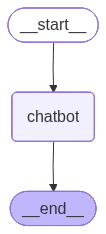

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input }]}):
        for value in event.values():
            print("Assistant: ", value["messages"].content)

stream_graph_updates("안녕 오늘은 무슨 요일이야?")


Assistant:  안녕하세요! 오늘은 2023년 10월 4일 수요일입니다. 도움이 필요하시면 언제든지 말씀해 주세요!


In [14]:
while True:
    user_input = input("You: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("goodbye!")
        break
    stream_graph_updates(user_input)

User:  안녕
Assistant:  안녕하세요! 어떻게 도와드릴까요?
User:  너 뭐할수 있어
Assistant:  저는 다양한 질문에 답변하고, 정보 제공, 글쓰기, 번역, 아이디어 제안, 문제 해결 등 여러 가지 작업을 도와드릴 수 있습니다. 궁금한 점이나 필요한 것이 있다면 말씀해 주세요!
User:  나각자
Assistant:  "나각자"는 "각자"라는 의미로, 각 개인이 자신만의 방식이나 입장에서 어떤 일을 한다는 뜻입니다. 더 구체적인 질문이나 설명이 필요하시면 말씀해 주세요!
User:  중지해줘
Assistant:  무엇을 중지해드릴까요? 더 구체적으로 말씀해 주시면 도와드리겠습니다.
User:  ㅂ
Assistant:  안녕하세요! 무엇을 도와드릴까요?
User:  q
goodbye!


# 챗봇 메모리 추가하기 (Multi-turn) 

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


In [30]:
graph = graph_builder.compile(checkpointer=memory)



In [31]:
# 대화 메모리를 thread_id 별로 저장 가능
config = {"configurable": {"thread_id": "1"}}


In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content":user_input}]}, config=config):
        for value in event.values():
            print("Assistant: ", value["messages"].content)




Assistant:  안녕하세요! 오늘은 2023년 10월 4일 수요일입니다. 도움이 필요하시면 언제든지 말씀해 주세요!


In [33]:
while True:
    user_input = input("You: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("goodbye!")
        break
    
    stream_graph_updates(user_input)

graph.get_state(config)

User:  안녕 내이름은 예지야
Assistant:  안녕하세요, 예지님! 만나서 반가워요. 어떤 이야기를 나누고 싶으신가요?
User:  ㅂ
Assistant:  무언가 궁금한 점이나 이야기하고 싶은 것이 있으면 말씀해 주세요! 도와드릴 준비가 되어 있습니다.
User:  q
goodbye!


StateSnapshot(values={'messages': [HumanMessage(content='안녕 오늘은 무슨 요일이야?', additional_kwargs={}, response_metadata={}, id='eefe47e3-8879-40f7-927f-05dada6d5d16'), AIMessage(content='안녕하세요! 오늘은 2023년 10월 4일 수요일입니다. 도움이 필요하시면 언제든지 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 18, 'total_tokens': 48, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CRzC8TtUoOqFc4NteFFz5Q695qf2k', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c1e5e949-ddc5-4d35-84dc-4b3fd46b6a15-0', usage_metadata={'input_tokens': 18, 'output_tokens': 30, 'total_tokens': 48, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 

In [34]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='안녕 오늘은 무슨 요일이야?', additional_kwargs={}, response_metadata={}, id='eefe47e3-8879-40f7-927f-05dada6d5d16'), AIMessage(content='안녕하세요! 오늘은 2023년 10월 4일 수요일입니다. 도움이 필요하시면 언제든지 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 18, 'total_tokens': 48, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CRzC8TtUoOqFc4NteFFz5Q695qf2k', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c1e5e949-ddc5-4d35-84dc-4b3fd46b6a15-0', usage_metadata={'input_tokens': 18, 'output_tokens': 30, 'total_tokens': 48, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 